In [1]:
import pandas as pd
from collections import defaultdict
import os
from datetime import datetime
from scipy.stats import ttest_ind
from numpy import mean

In [2]:
#set constants

sources = ["Il Giornale"]

start_collection = '2019-11-10'
start_polarization = '2019-11-20'


timerange = ('2019-11-20',
             '2019-12-03')


folder = '../outputs/fb/summary'
file_users =  '../config/users.csv'


In [3]:
#load all impressions, filtering useful fields and replacing hased names with fb names


def absoluteFilePaths(directory):
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            if str(f)[0] == '.':
                pass
            else:
                yield os.path.abspath(os.path.join(dirpath, f))

def getImpressions(folder):
    impressions = pd.DataFrame()
    files = absoluteFilePaths(folder)
    tokens2names = pd.read_csv(file_users)
    for impressions_file in files:
        user_impressions = pd.read_csv(impressions_file)[['impressionTime', 'user', 'source']] #you can add fields of interest here
        name = tokens2names[tokens2names['token'] == impressions_file.split('/')[-1].split('.')[0]]['name'].values[0]
        user_impressions['user'] = name
        impressions = pd.concat([impressions, user_impressions])      
    return impressions

impressions = getImpressions(folder)



In [4]:
#filter out for desired time range for experiment


impressions_exp = impressions[(impressions['impressionTime'] >= timerange[0]) 
                        & (impressions['impressionTime'] <= timerange[1])]




In [5]:
#count specific sources per user


def count_sources(impressions, sources):
    sources_users = {"source": [],
                     "user": [],
                     "count": []}
    for source in sources:
        for user, user_impressions in impressions.groupby('user'):
            sources_users["source"].append(source)
            sources_users["user"].append(user)
            sources_users["count"].append(user_impressions[user_impressions["source"] == source]["source"].count())       
    return pd.DataFrame(data = sources_users)

sources_users = count_sources(impressions_exp, sources)


In [6]:
#exclude salvini+lega in order to harmonize shares across polarized and control

impressions_exp = impressions_exp[(impressions_exp["source"] != "Matteo Salvini") 
                        & (impressions_exp["source"] != "Lega - Salvini Premier")]

In [7]:
#normalize counts dividing for total impression per user

users_totalcount = impressions_exp.groupby(['user'])["source"].count()


sources_users["tot_count"] = [users_totalcount[user]
                              for user in sources_users["user"]] 

sources_users["share_count"] = (sources_users["count"] / sources_users["tot_count"])*100



In [8]:
#fiter impressions pre-polarization and harmonize counts on initial distribution of sources

impressions_pre = impressions[(impressions['impressionTime'] <= start_polarization) & (impressions['impressionTime'] >= start_collection)] 

sources_users_pre = count_sources(impressions_pre, sources)

users_totalcount = impressions_pre.groupby(['user'])["source"].count()

sources_users_pre["tot_count"] = [users_totalcount[user]
                                  for user in sources_users_pre["user"]] 

sources_users_pre["share_count"] = (sources_users_pre["count"] / sources_users_pre["tot_count"])*100


sources_users["share_count_adj"] = sources_users["share_count"] / sources_users_pre["share_count"]

          

In [9]:
#add column with test group the user belongs to
polarized_users = ('Aarend','Bjoke','CorTimmerman','Doortje','Erwijn','Friedie','Gert','Hanneke','Ivo','Juultje')

sources_users["user_group"] = ["polarized" if user in polarized_users 
                                         else "control" 
                             for user in sources_users["user"]]        

In [17]:
#compare means and run t-test

polarized = sources_users[sources_users['user_group'] == 'polarized']["share_count_adj"]
control = sources_users[sources_users['user_group'] == 'control']["share_count_adj"]


print(mean(polarized))
print(mean(control))

ttest_ind(polarized, control)


1.3058232101236897
0.8808976011183252


Ttest_indResult(statistic=1.5779362913516735, pvalue=0.13199246428894354)

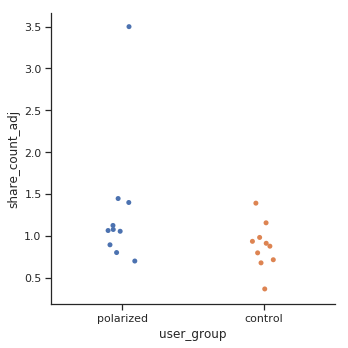

In [19]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)


groups_data = sources_users[["share_count_adj","user_group"]]


sns.catplot(x= "user_group", y= "share_count_adj", data= groups_data);